# Surrogate testing for behaviour of ant colonies

## Notes

Hypotheses to Test

- **Directional Homogeneity Across Time:**

- Hypothesis: Ant movement directions (represented by angle data) are uniformly distributed and do not change predictably over time.
- Surrogate Data: Generate surrogate datasets by randomly shuffling the angle data across all time points, breaking any temporal dependency but keeping the distribution of angles.


- **Speed Consistency Within and Across Ants:**

- Hypothesis: The speed of ants does not vary significantly between different ants or within the same ant over time.
- Surrogate Data: You can randomize the speed entries across all ants or within each ant to create surrogate datasets that maintain the overall statistical properties (like mean and variance) but lack any intrinsic patterns related to specific ants or time periods.


- **Spatial Distribution and Interaction:**

- Hypothesis: Ants distribute themselves randomly within a given space, without any particular patterns or clustering.
- Surrogate Data: Randomize the (x, y) positions of the ants either completely or within constrained regions (to maintain plausible movements) to test for non-random clustering or pathways.


Steps to Conduct Surrogate Testing

- Select Your Hypothesis: Decide on which aspect of the ants' behavior you are most interested in. This will determine what kind of data randomization is necessary.
- Generate Surrogate Data: Based on the selected hypothesis, generate multiple surrogate datasets. For example, if testing for directional homogeneity, shuffle the angle data while keeping other parameters constant.
- Statistical Analysis:
Calculate statistics relevant to your hypothesis for both the observed and surrogate datasets (e.g., mean, variance, clustering indices, autocorrelation).
Compare these statistics using tests like t-tests, chi-square tests, or more complex models like regression analysis if applicable.
- Interpret Results: Determine whether there are significant differences between the statistics from your observed dataset and the surrogate datasets. Significant differences suggest non-random structures or behaviors in your data.
- Report Findings: Present your methodology, analysis, and conclusions. Discuss possible biological implications of your findings regarding ant behavior and colony dynamics.

## Plan

- Extract 1 dimensional metrics for either individual behaviour or collective behaviour, from individual x y coordinates.
Generate appropiate data for surrogate testing

- Metrics 
Collective centre of mass shift amplitude
number of clusters of given radius / total number of ants in clusters / total number of ants without other ant in certain radius

- Surrogate data
by AAFT - surrogate data must have the same autocorrelation to account for spatio temporal nature of the observed data - CoM shift
or data shuffling - cluster property comparisons

- We gonna know whether collective movement behaviours occur at size and rate of chance (chance given certain assumptions that defined the generated data)






extract measures - test against random
number of ant clusters
total distance between ants




## Setup

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from os.path import join

In [93]:
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
import multiSyncPy


## Extract new features

In [94]:
def get_nth_colony(n):
    ant_data = get_ant_datafiles_info()
    df = preprocess_antcolony_data(ant_data['file'][n])
    return df


In [96]:
def add_features(df):
    
    # center of mass of the whole ant colony at each frame
    centers_of_mass = df.groupby('frameno')[['x', 'y']].mean().reset_index()
    df = df.merge(centers_of_mass, on='frameno', suffixes=('', '_CoM'))
    
    # distance to center of mass of each ant at each frame
    df['distance_to_CoM'] = np.sqrt((df['x'] - df['x_CoM'])**2 + (df['y'] - df['y_CoM'])**2)

    # polar coordinates of each ant with respect to the origin of cartesian coordinates
    df['polar_dist'] = np.sqrt(df['x']**2 + df['y']**2)
    df['polar_angle'] = np.arctan2(df['y'], df['x'])
    # Convert angle from radians to degrees
    df['polar_angle'] = np.degrees(df['polar_angle'])

    close_ants_count = df.groupby('frameno').apply(count_close_ants)
    close_ants_count_df = close_ants_count.reset_index()
    close_ants_count_df.columns = ['frameno', 'close_ants_count']

    return df


def count_close_ants(group):
    # Extract coordinates
    coordinates = group[['x', 'y']].to_numpy()
    n = len(coordinates)
    close_count = 0
    
    # Calculate pairwise distances
    for i in range(n):
        # Compute distances from the ith ant to all other ants
        distances = np.sqrt(np.sum((coordinates - coordinates[i])**2, axis=1))
        
        # Check if there is at least one ant closer than 20 units, excluding the ant itself
        if np.any((distances > 0) & (distances < 100)):
            close_count += 1
    
    return close_count   
    

In [129]:
colonies = [ ]
for i in range (10):
    colonies.append(f'df{i}')
    exec(f'df{i} = get_nth_colony({i})')
    exec(f'df{i} = add_features(df{i})')

/tmp/ipykernel_14905/1010034553.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_14905/1010034553.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_14905/1010034553.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

## Plots

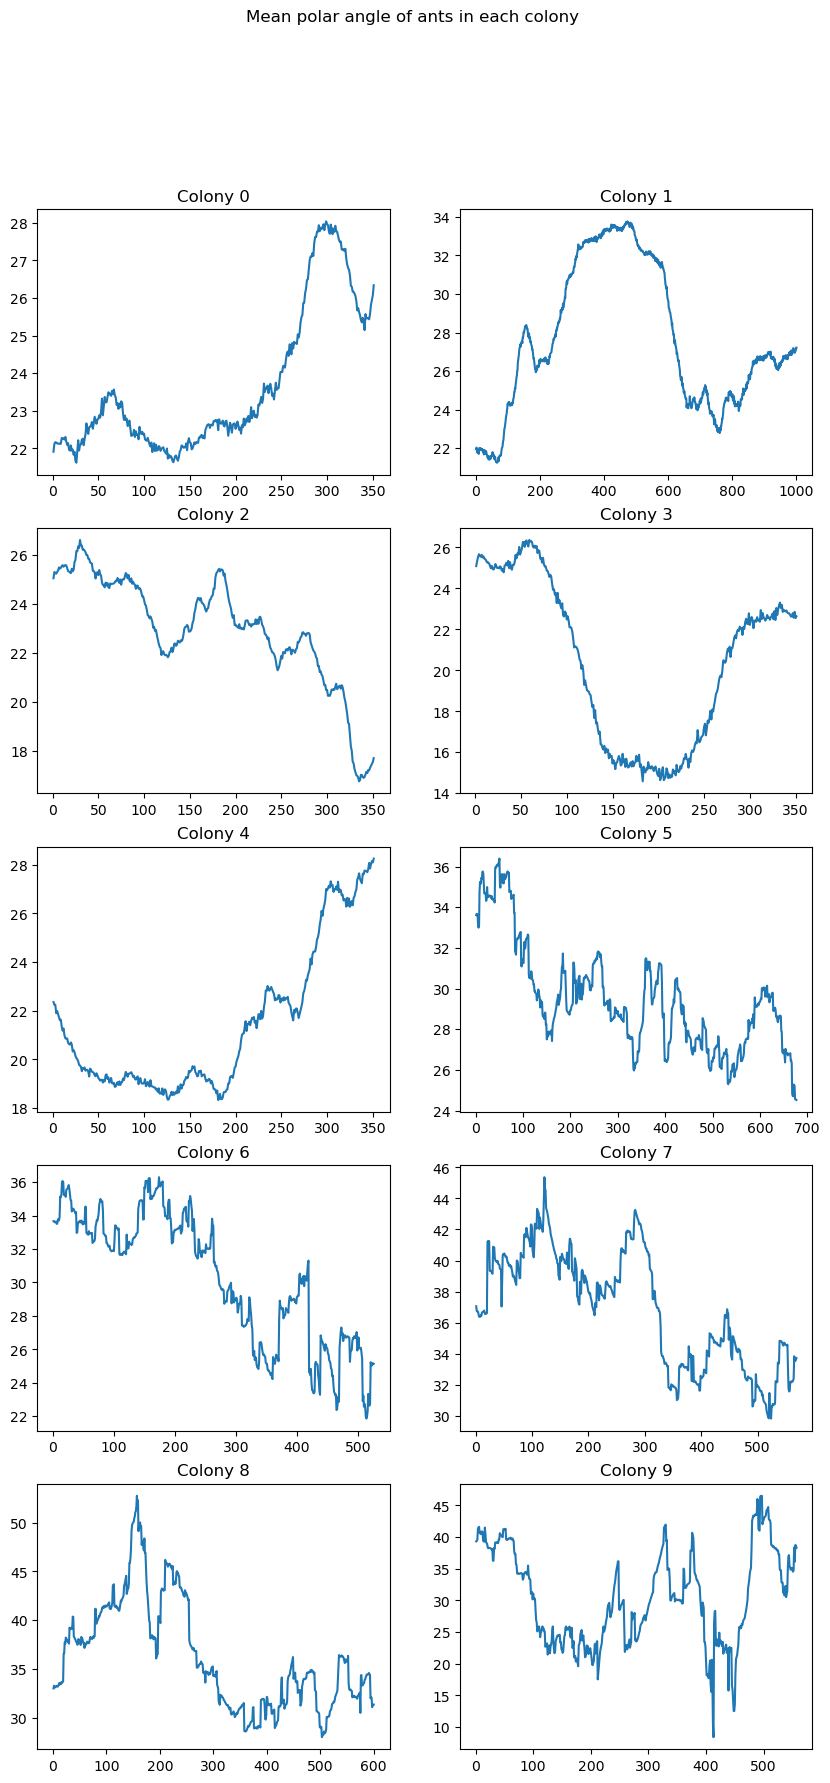

In [162]:
plt.figure(figsize=(10, 20))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    plt.plot(df.groupby('frameno')['polar_angle'].mean())
plt.suptitle('Mean polar angle of ants in each colony')
plt.show()


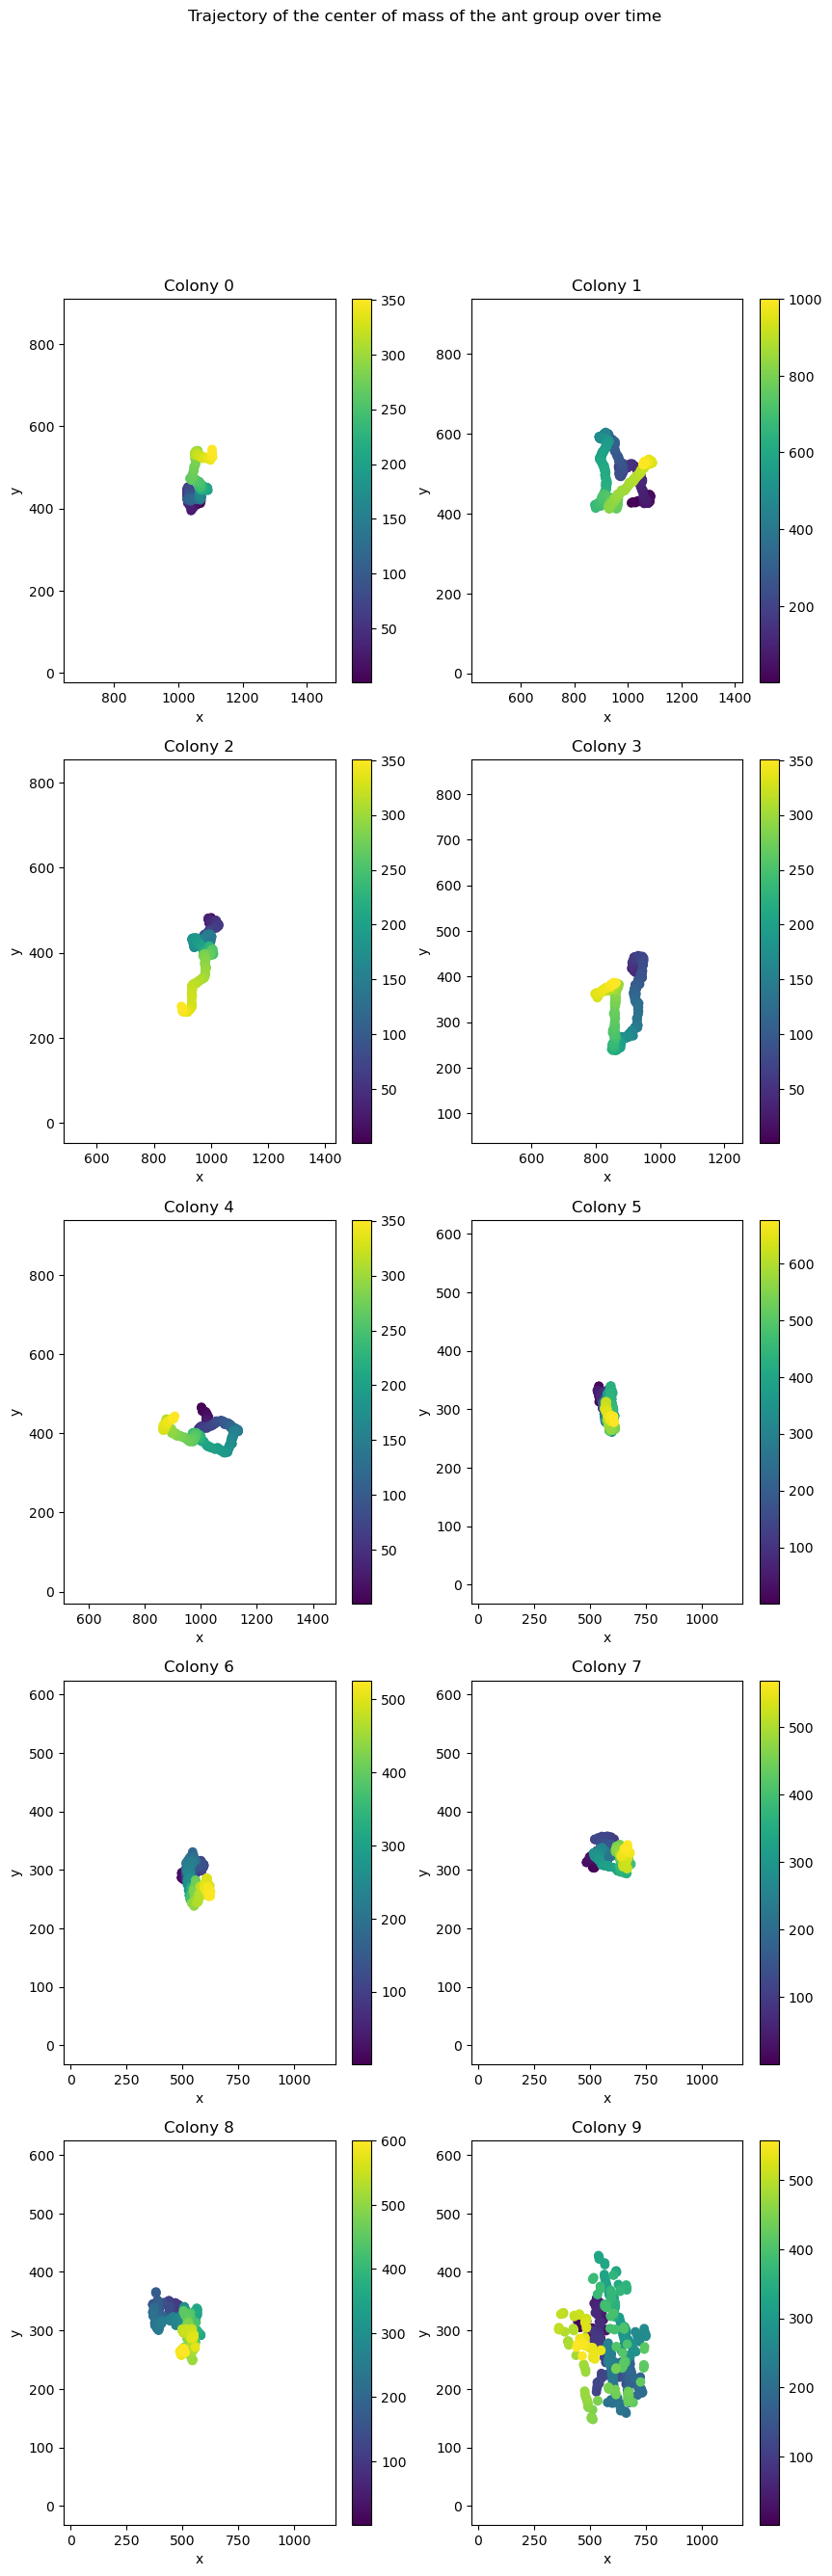

In [152]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    centers_of_mass = df.groupby('frameno')[['x', 'y']].mean().reset_index()
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    plt.scatter(centers_of_mass['x'], centers_of_mass['y'], c=centers_of_mass['frameno'])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(df['x'].min(), df['x'].max())
    plt.ylim(df['y'].min(), df['y'].max())

plt.suptitle('Trajectory of the center of mass of the ant group over time')
plt.show()

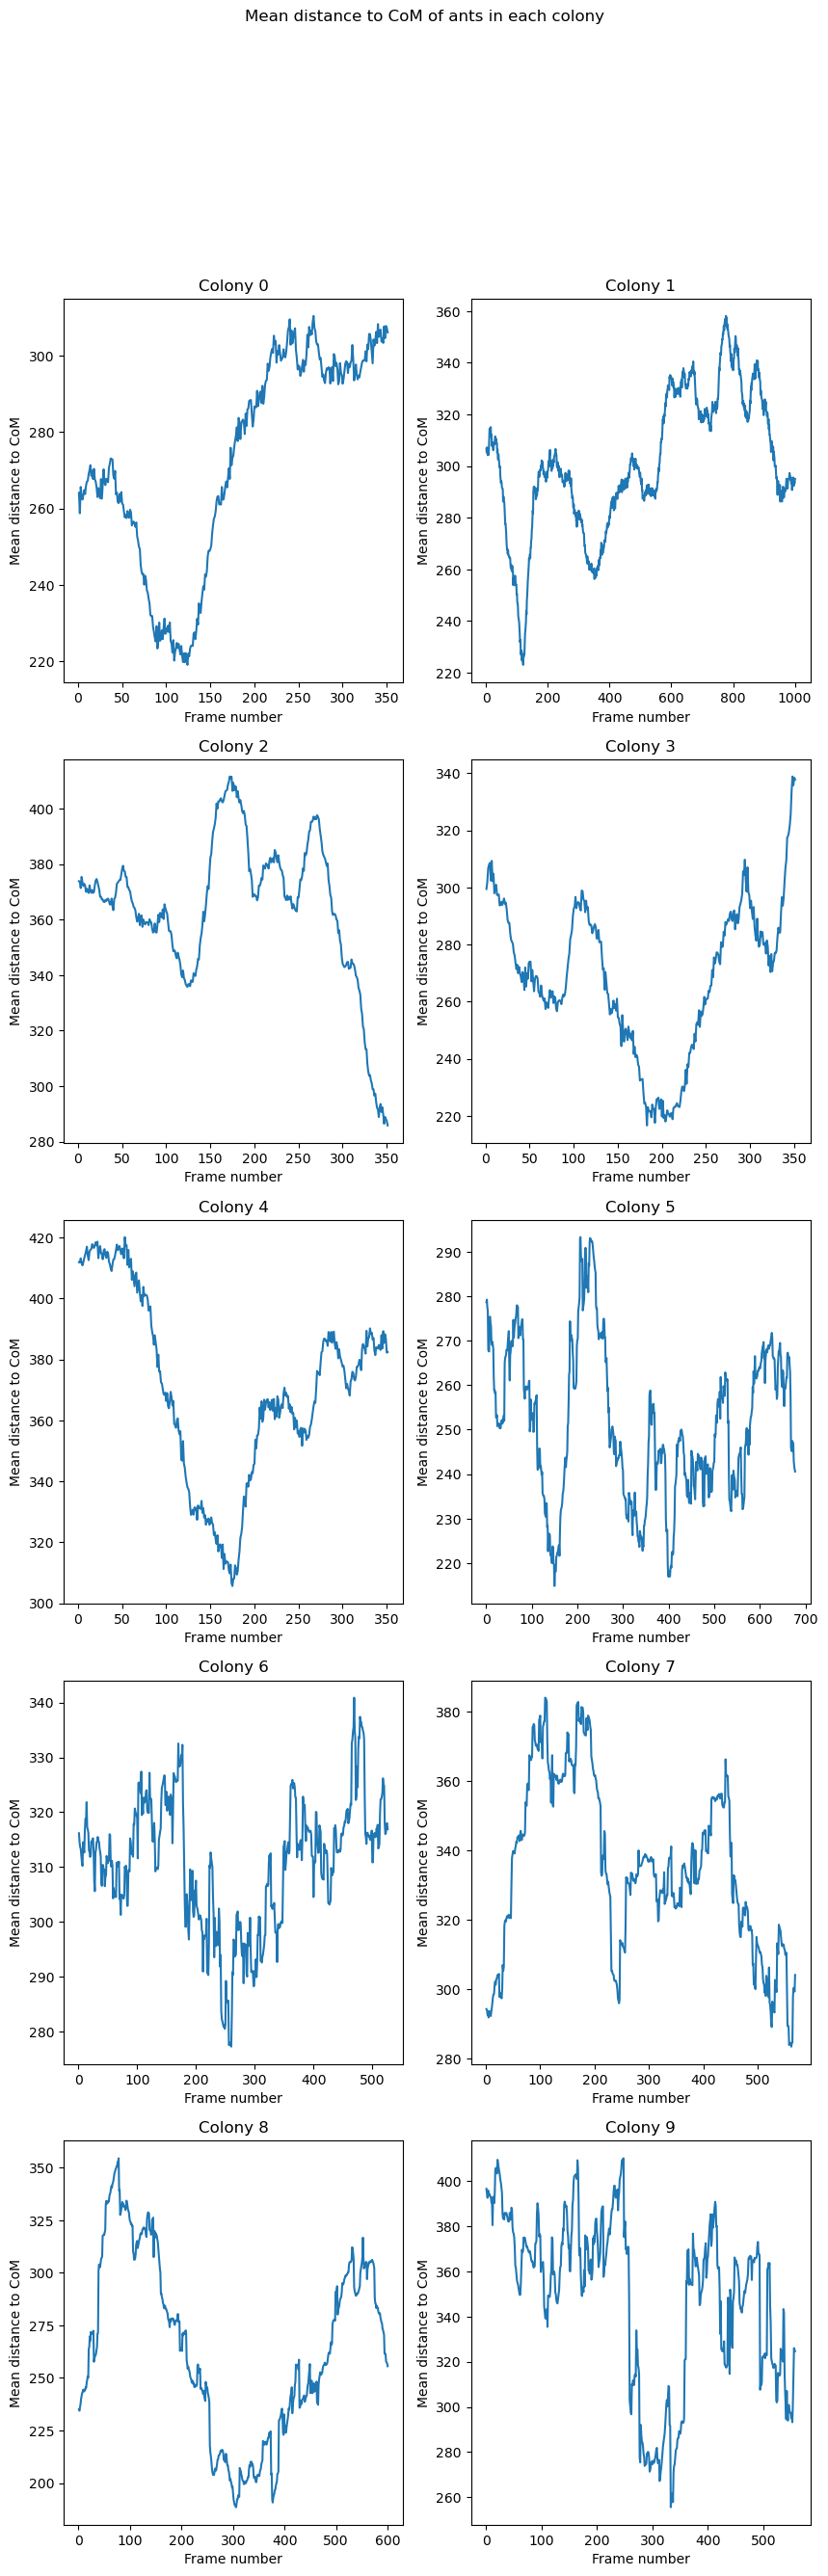

In [147]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    mean_distance = df.groupby('frameno')['distance_to_CoM'].mean().reset_index()
    plt.plot(mean_distance['frameno'], mean_distance['distance_to_CoM'])
    plt.xlabel('Frame number')
    plt.ylabel('Mean distance to CoM')
plt.suptitle('Mean distance to CoM of ants in each colony')
plt.show()


/tmp/ipykernel_14905/3085975008.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_14905/3085975008.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_14905/3085975008.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

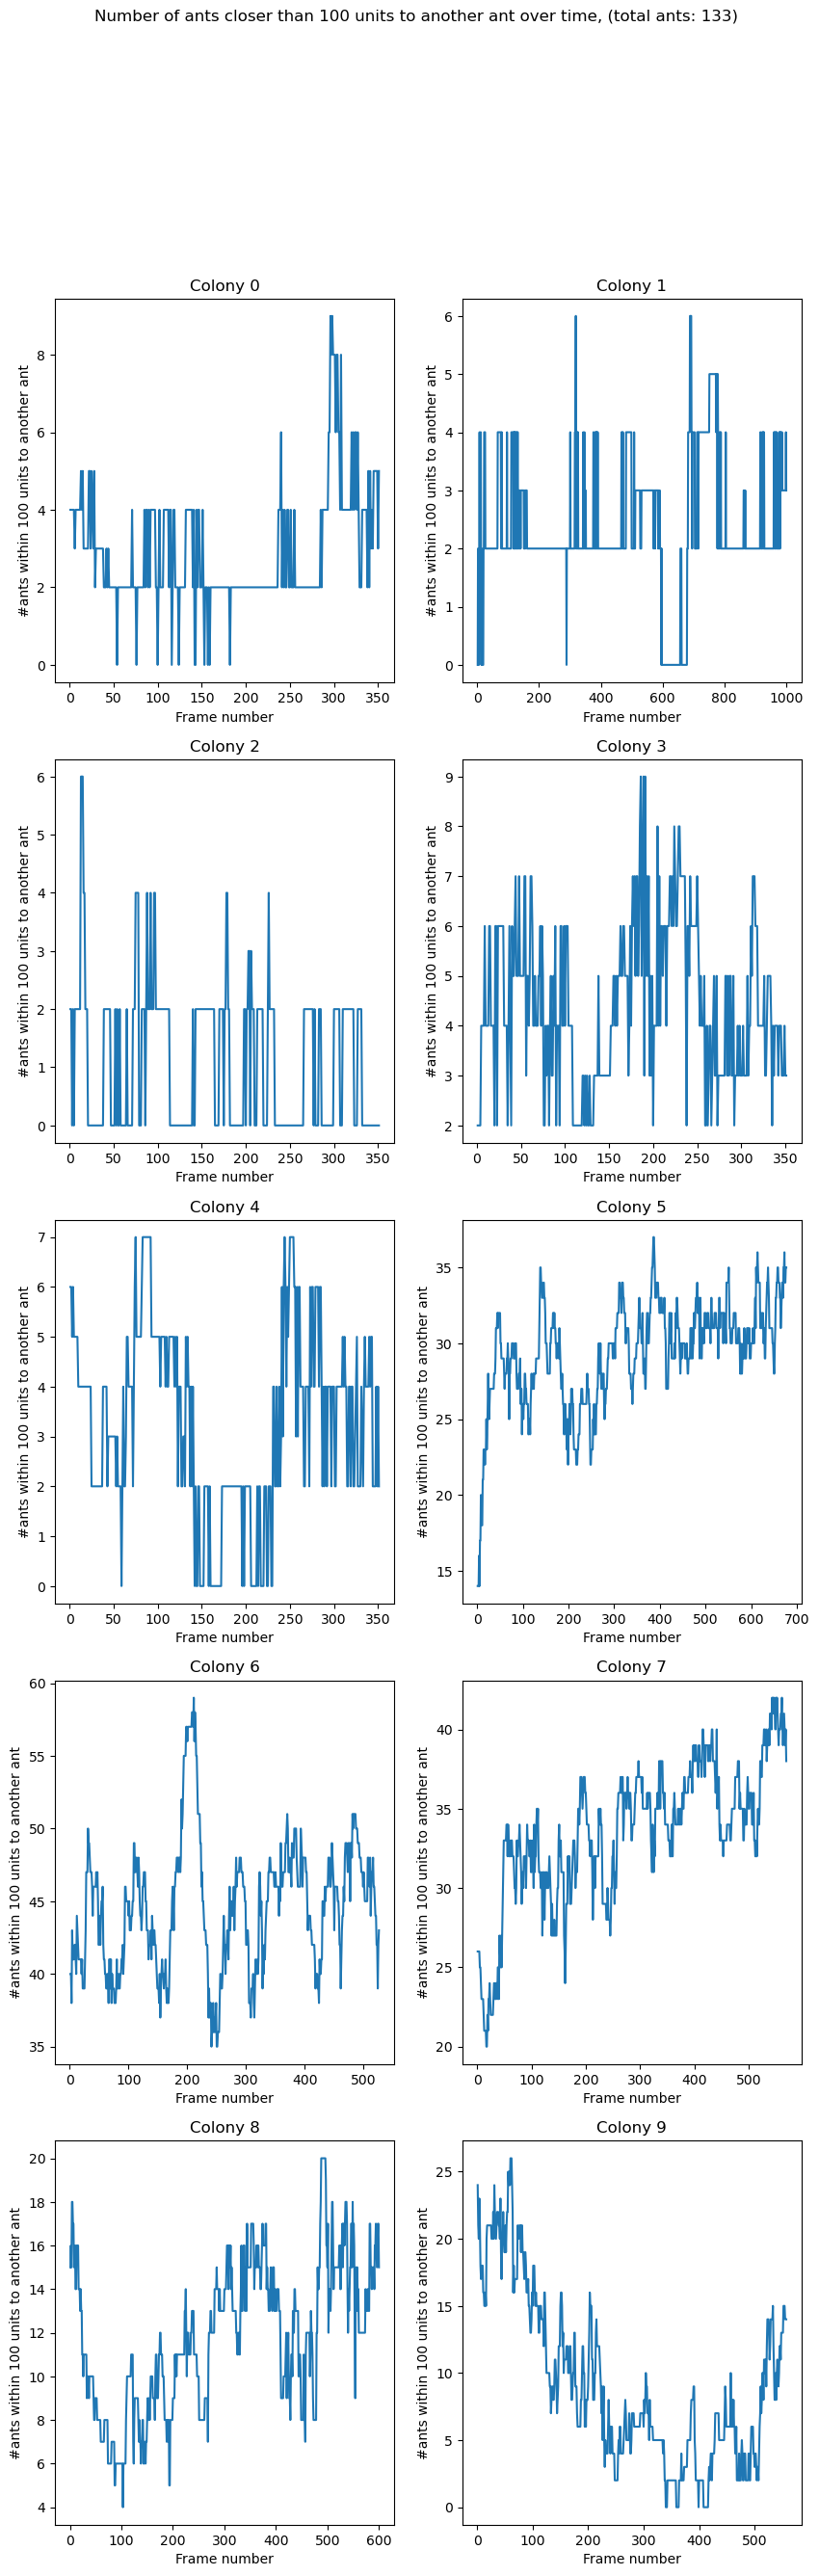

In [156]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    close_ants_count = df.groupby('frameno').apply(count_close_ants)
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    plt.plot(close_ants_count)
    plt.xlabel('Frame number')
    plt.ylabel('#ants within 100 units to another ant')
plt.suptitle(f'Number of ants closer than 100 units to another ant over time, (total ants: {df['ant_id'].nunique()})')
plt.show()

- fluctuating
- ants might change their behaviour based on observing the number of ants around them
- too much -> go away
- too few -> stay
- lets quantify this effect over all colony
- lets test this by surrogate testing

## Ants outside frame

In [108]:
for i in range(10):
    df = get_nth_colony(i)
    print(f'image size for colony {i}: ({df["x"].min()} - {df["x"].max()}) x ({df["y"].min()} - {df["y"].max()})')

image size for colony 0: (642.112 - 1489.17) x (-22.6184 - 910.094)
image size for colony 1: (415.518 - 1428.72) x (-22.6184 - 939.0)
image size for colony 2: (483.225 - 1435.97) x (-47.0 - 855.165)
image size for colony 3: (413.099 - 1257.03) x (35.4169 - 876.928)
image size for colony 4: (509.82500000000005 - 1479.5) x (-29.8728 - 939.0)
image size for colony 5: (-32.0 - 1184.0) x (-32.0 - 624.0)
image size for colony 6: (-32.0 - 1184.0) x (-32.0 - 624.0)
image size for colony 7: (-32.0 - 1184.0) x (-32.0 - 624.0)
image size for colony 8: (-32.0 - 1184.0) x (-32.0 - 624.0)
image size for colony 9: (-32.0 - 1184.0) x (-32.0 - 624.0)


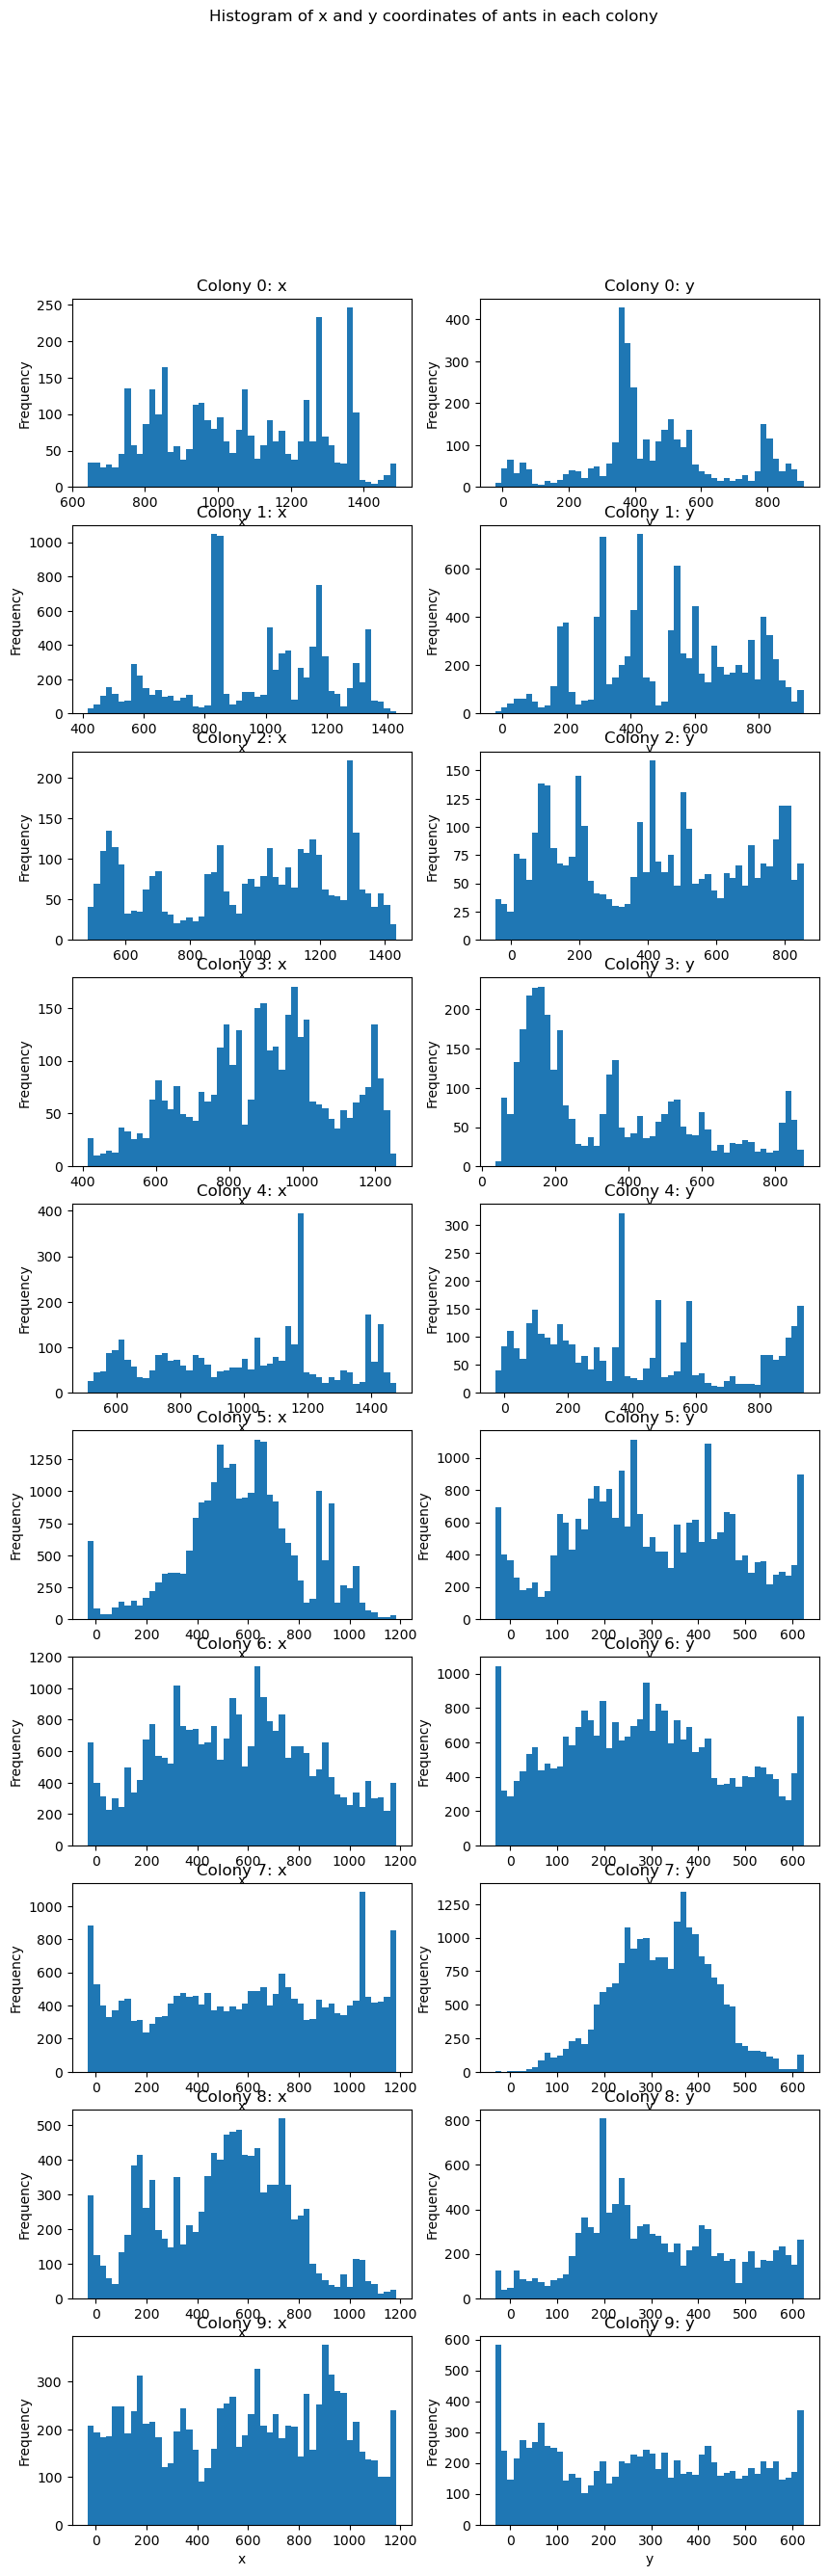

In [161]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(10, 2, i*2 + 1)
    plt.title(f'Colony {i}: x')
    plt.hist(df['x'], bins=50)
    plt.xlabel('x')
    plt.ylabel('Frequency')

    plt.subplot(10, 2, i*2 + 2)
    plt.title(f'Colony {i}: y')
    plt.hist(df['y'], bins=50)
    plt.xlabel('y')
    plt.ylabel('Frequency')
    
plt.suptitle('Histogram of x and y coordinates of ants in each colony')
plt.show()

- uniform and gaussian like distributions with local peaks at the sides show ants that left the frame
- noticable at colony 5xy, 6xy, 7xy, 8xy, 9xy - outdoor colonies

## Correlations

data seems random

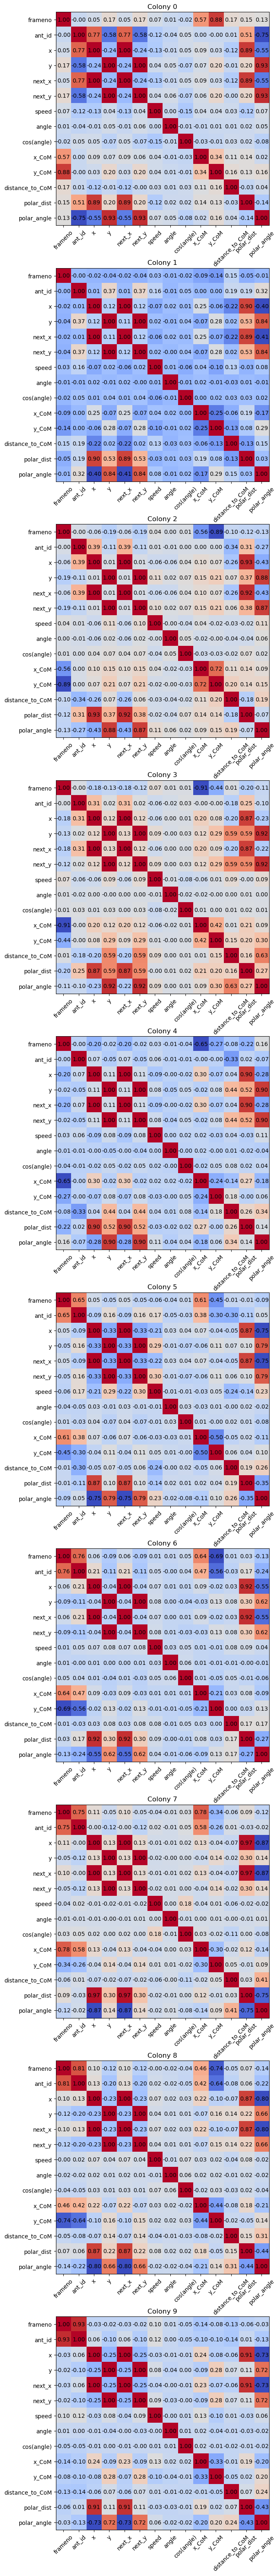

In [168]:
# plot a correlation hetmap

plt.figure(figsize=(15, 80))
for i in range(10):
    exec(f'df = df{i}')
    corr = df.corr()
    plt.subplot(10, 1, i+1)
    plt.title(f'Colony {i}')
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.columns)), corr.columns)
    # display correlation values
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(i, j, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')

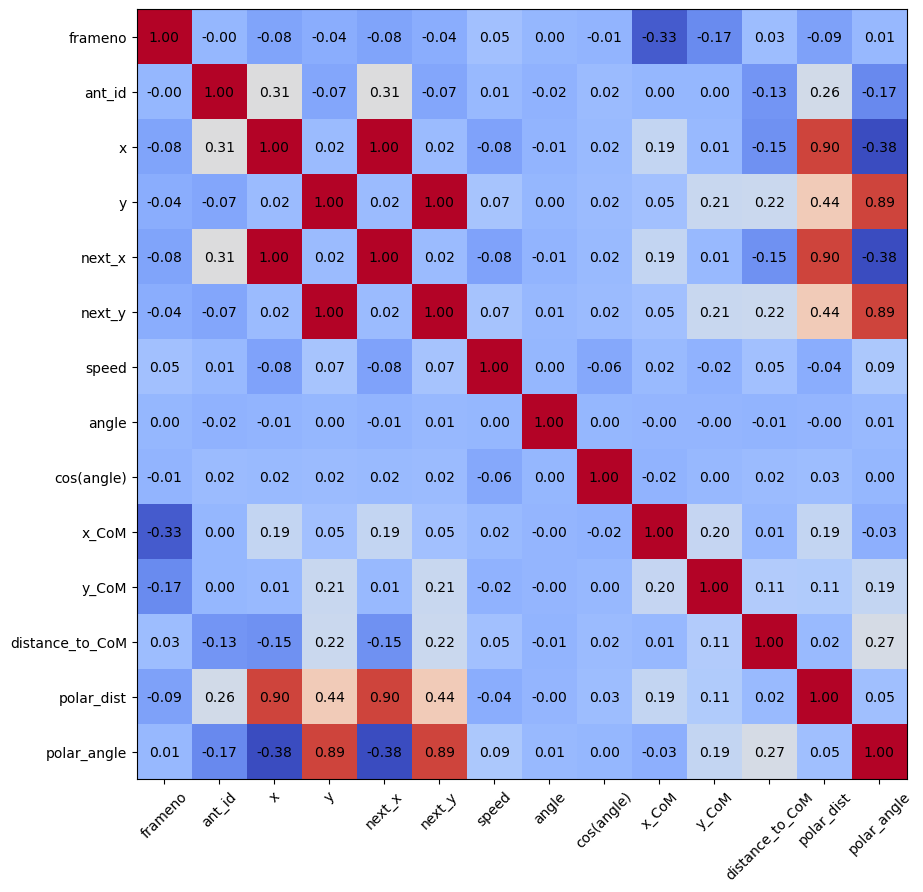

In [171]:
# plot the mean off correlation matrixes for colonies 1 to 5
plt.figure(figsize=(10, 10))
mean_corrs = []
for i in range(5):
    exec(f'df = df{i}')
    mean_corrs.append(df.corr())
mean_corr = sum(mean_corrs) / 5
plt.imshow(mean_corr, cmap='coolwarm', interpolation='none')
plt.xticks(range(len(mean_corr.columns)), mean_corr.columns, rotation=45)
plt.yticks(range(len(mean_corr.columns)), mean_corr.columns)
# display correlation values
for i in range(len(mean_corr.columns)):
    for j in range(len(mean_corr.columns)):
        plt.text(i, j, f'{mean_corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')


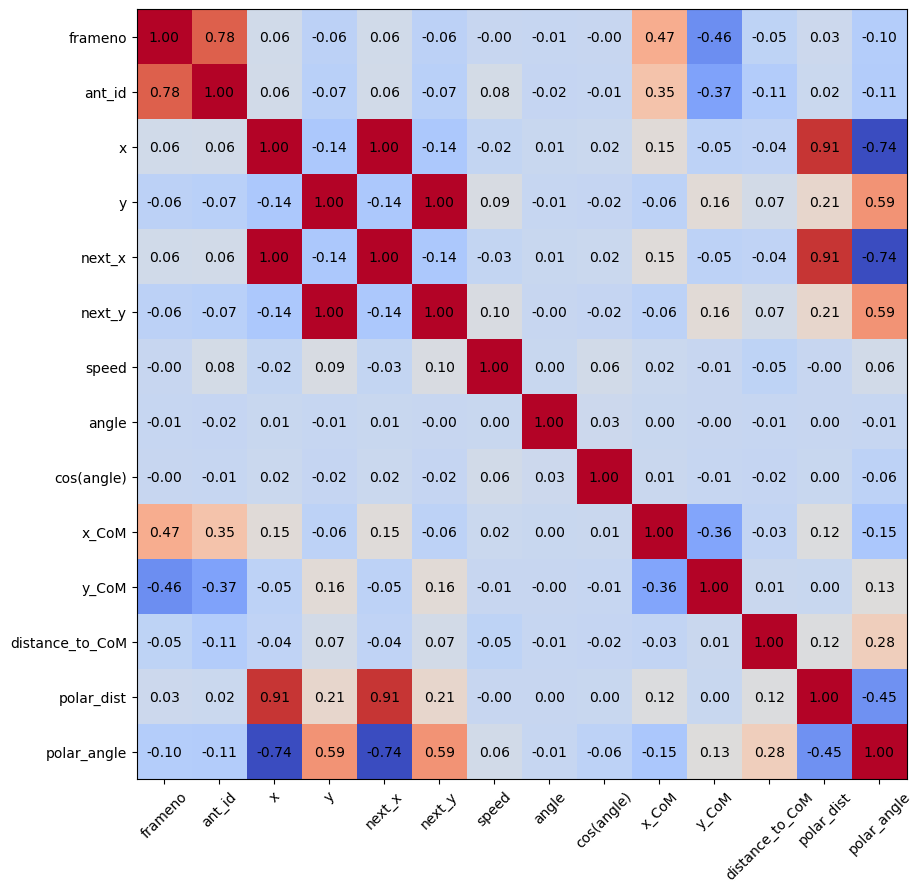

In [172]:
# plot the mean off correlation matrixes for colonies 6 to 10
plt.figure(figsize=(10, 10))
mean_corrs = []
for i in range(5, 10):
    exec(f'df = df{i}')
    mean_corrs.append(df.corr())
mean_corr = sum(mean_corrs) / 5
plt.imshow(mean_corr, cmap='coolwarm', interpolation='none')
plt.xticks(range(len(mean_corr.columns)), mean_corr.columns, rotation=45)
plt.yticks(range(len(mean_corr.columns)), mean_corr.columns)
# display correlation values
for i in range(len(mean_corr.columns)):
    for j in range(len(mean_corr.columns)):
        plt.text(i, j, f'{mean_corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')


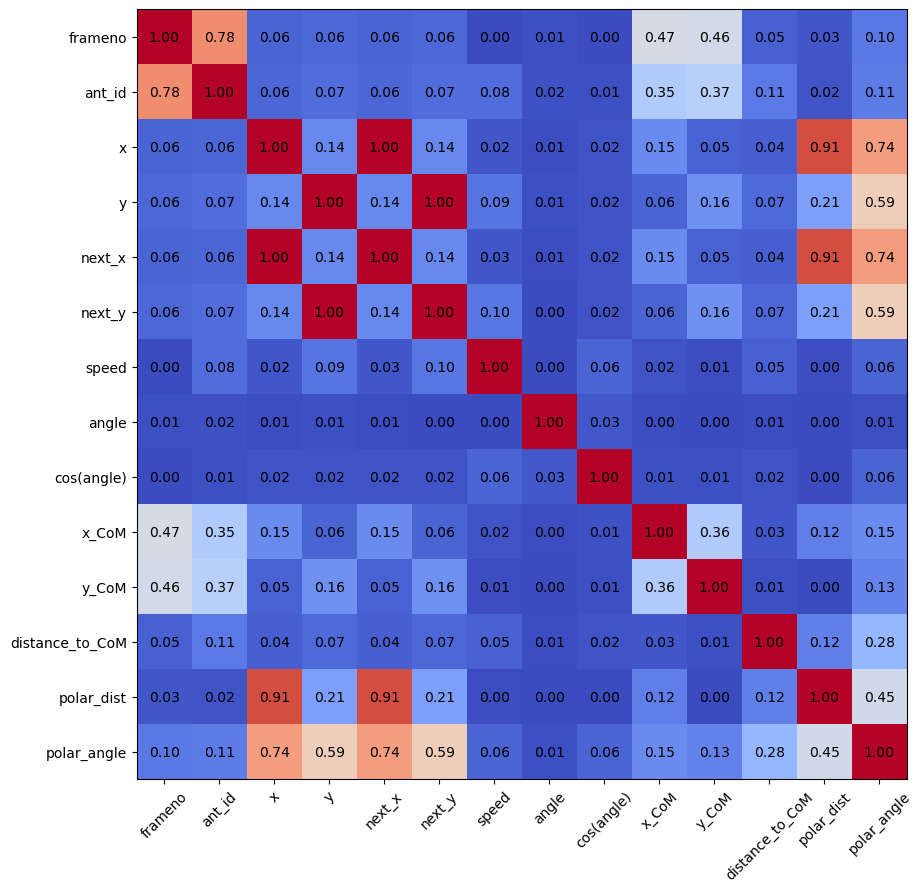

In [174]:
# plot the differences between the mean correlation matrixes of colonies 1 to 5 and 6 to 10
plt.figure(figsize=(10, 10))
mean_corrs1 = []
for i in range(5):
    exec(f'df = df{i}')
    mean_corrs1.append(df.corr())
mean_corr1 = sum(mean_corrs1) / 5
mean_corrs2 = []
for i in range(5, 10):
    exec(f'df = df{i}')
    mean_corrs1.append(df.corr())
mean_corr2 = sum(mean_corrs1) / 5
mean_corr_diff = abs(mean_corr1 - mean_corr2)
plt.imshow(mean_corr_diff, cmap='coolwarm', interpolation='none')
plt.xticks(range(len(mean_corr_diff.columns)), mean_corr_diff.columns, rotation=45)
plt.yticks(range(len(mean_corr_diff.columns)), mean_corr_diff.columns)
# display correlation values
for i in range(len(mean_corr_diff.columns)):
    for j in range(len(mean_corr_diff.columns)):
        plt.text(i, j, f'{mean_corr_diff.iloc[i, j]:.2f}', ha='center', va='center', color='black')

## Hypothesis 1

ants move at random

### Create surrogate data